# ANN Constraint Training Test

In [18]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import argparse
import scipy.io

In [19]:
# Define the classifier architecture
class Classifier(nn.Module):
    def __init__(self, input_size):
        super(Classifier, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 64)
        self.func1 = nn.Sigmoid()
        
        self.fc2 = nn.Linear(64, 32)
        self.func2 = nn.Sigmoid()
        
        self.fc3 = nn.Linear(32, 16)
        self.func3 = nn.Sigmoid()
        
        self.fc4 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        
        x = self.fc1(x)
        x = self.func1(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.func2(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.func3(x)
        x = self.dropout(x)
        
        x = self.fc4(x)
        x = self.relu(x)
        
        #x = self.dropout(x)
        
        return x
'''  
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x
'''  

'  \n        super(Classifier, self).__init__()\n        self.fc1 = nn.Linear(input_size, 64)\n        self.relu = nn.ReLU()\n        self.fc2 = nn.Linear(64, 32)\n        self.fc3 = nn.Linear(32, 1)\n        self.sigmoid = nn.Sigmoid()\n\n    def forward(self, x):\n        x = self.fc1(x)\n        x = self.relu(x)\n        x = self.fc2(x)\n        x = self.relu(x)\n        x = self.fc3(x)\n        x = self.sigmoid(x)\n        return x\n'

In [20]:
mat_input = scipy.io.loadmat('C:/Users/D3H8678/Master_Thesis/mooinverter/TestFolder/MOO/inverter/10000_input_data.mat')
mat_target = scipy.io.loadmat('C:/Users/D3H8678/Master_Thesis/mooinverter/TestFolder/MOO/inverter/ANN_Training/10000_Target.mat')
#Get scaled input and Target data
input_scaled = mat_input.get('input_scaled')

output = mat_target.get('Target')

amount_of_rows = 7000

# Generate random indices for the rows to remove
indices_to_remove = np.random.choice(input_scaled.shape[0], amount_of_rows, replace=False)

# Remove the specified rows from input_scaled and output
input_subset = np.delete(input_scaled, indices_to_remove, axis=0)
output_subset = np.delete(output, indices_to_remove, axis=0)

# Verify the shape of the resulting subsets
print(input_subset.shape)
print(output_subset.shape)

(3000, 7)
(3000, 1)


In [21]:
# Set device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Set data and target
data = torch.Tensor(input_subset)
target = torch.Tensor(output_subset)

# Split the data into training, validation, and testing sets 
#test_size = 0.2 ist 80% Training set
train_data, test_data, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42
)

#test_size hier auf 0.5 heißt die übrigen 20% nochmal in 10% für val und 10% für test
val_data, test_data, val_target, test_target = train_test_split(
    test_data, test_target, test_size=0.5, random_state=42
)

# Create data loaders
train_dataset = TensorDataset(train_data, train_target)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(val_data, val_target)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataset = TensorDataset(test_data, test_target)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
# Initialize the model
model = Classifier(input_size=7).to(device)
test_accuracies = []
best_test_accuracy = 0.0
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.01)
#optimizer = optim.RMSprop(model.parameters(), lr=0.01) -> 96% # (Levenberg optimizer nur 
#für feedforward oder bei tensorflow!)  
#optimizer = optim.SGD(model.parameters(), lr=0.001) -->66%
# Training loop
num_epochs = 200
best_val_loss = float("inf")
train_losses = []
patience = 10  # Number of epochs to wait for improvement
no_improvement = 0  # Counter for epochs without improvement
model.train()
for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    # Training
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        labels = labels.squeeze()
        loss = criterion(outputs.squeeze(), labels.float())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    #Stop epoch if validation doesnt improve
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            labels = labels.squeeze()
            loss = criterion(outputs.squeeze(), labels.float())

            val_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)  # Append train loss to the list
    val_loss /= len(val_loader)

    print(
        f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
    )
    
'''
  # Check for improvement in validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        no_improvement += 1
        
    # Stop training if no improvement in validation loss for a certain number of epochs
    if no_improvement >= patience:
        print("Early stopping. No improvement in validation loss.")
        break
 '''   

# Save the best model based on validation loss
if val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(model.state_dict(), "best_model.pt")
     

# Load the best model
model.load_state_dict(torch.load("best_model.pt"))

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        predicted = torch.round(outputs)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_accuracy = (correct / total) * 100
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    test_accuracies.append(test_accuracy)

    # Save the best model based on test accuracy
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        string = "best_model_{0}_epoch_{1}_loss_{2}_optimizer_{3}_lr_{4}_dropout_{5}_data-size_{6}.pt".format(
            best_test_accuracy, num_epochs, string_loss, string_optimizer, lr, dropout_number[10:14], data.size(0))
        torch.save(model.state_dict(), string)

Epoch [1/200], Train Loss: 0.2556, Val Loss: 0.2147
Epoch [2/200], Train Loss: 0.2041, Val Loss: 0.1478
Epoch [3/200], Train Loss: 0.1643, Val Loss: 0.1337
Epoch [4/200], Train Loss: 0.1502, Val Loss: 0.1306
Epoch [5/200], Train Loss: 0.1449, Val Loss: 0.1359
Epoch [6/200], Train Loss: 0.1421, Val Loss: 0.1253
Epoch [7/200], Train Loss: 0.1421, Val Loss: 0.1157
Epoch [8/200], Train Loss: 0.1399, Val Loss: 0.1139
Epoch [9/200], Train Loss: 0.1373, Val Loss: 0.1466
Epoch [10/200], Train Loss: 0.1327, Val Loss: 0.1115
Epoch [11/200], Train Loss: 0.1341, Val Loss: 0.1231
Epoch [12/200], Train Loss: 0.1312, Val Loss: 0.1229
Epoch [13/200], Train Loss: 0.1339, Val Loss: 0.1118
Epoch [14/200], Train Loss: 0.1322, Val Loss: 0.1121
Epoch [15/200], Train Loss: 0.1296, Val Loss: 0.1221
Epoch [16/200], Train Loss: 0.1262, Val Loss: 0.1053
Epoch [17/200], Train Loss: 0.1213, Val Loss: 0.1123
Epoch [18/200], Train Loss: 0.1145, Val Loss: 0.0901
Epoch [19/200], Train Loss: 0.1092, Val Loss: 0.0901
Ep

Epoch [156/200], Train Loss: 0.0385, Val Loss: 0.0399
Epoch [157/200], Train Loss: 0.0331, Val Loss: 0.0395
Epoch [158/200], Train Loss: 0.0340, Val Loss: 0.0424
Epoch [159/200], Train Loss: 0.0331, Val Loss: 0.0415
Epoch [160/200], Train Loss: 0.0332, Val Loss: 0.0363
Epoch [161/200], Train Loss: 0.0350, Val Loss: 0.0406
Epoch [162/200], Train Loss: 0.0359, Val Loss: 0.0565
Epoch [163/200], Train Loss: 0.0327, Val Loss: 0.0553
Epoch [164/200], Train Loss: 0.0318, Val Loss: 0.0429
Epoch [165/200], Train Loss: 0.0310, Val Loss: 0.0393
Epoch [166/200], Train Loss: 0.0320, Val Loss: 0.0395
Epoch [167/200], Train Loss: 0.0338, Val Loss: 0.0549
Epoch [168/200], Train Loss: 0.0368, Val Loss: 0.0490
Epoch [169/200], Train Loss: 0.0327, Val Loss: 0.0382
Epoch [170/200], Train Loss: 0.0331, Val Loss: 0.0383
Epoch [171/200], Train Loss: 0.0312, Val Loss: 0.0413
Epoch [172/200], Train Loss: 0.0292, Val Loss: 0.0454
Epoch [173/200], Train Loss: 0.0310, Val Loss: 0.0396
Epoch [174/200], Train Loss:

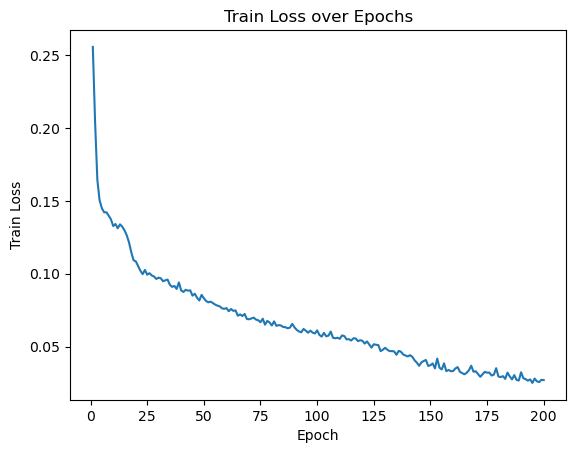

In [23]:
# Plotting the train loss
plt.plot(range(1, num_epochs+1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss over Epochs')
plt.show()